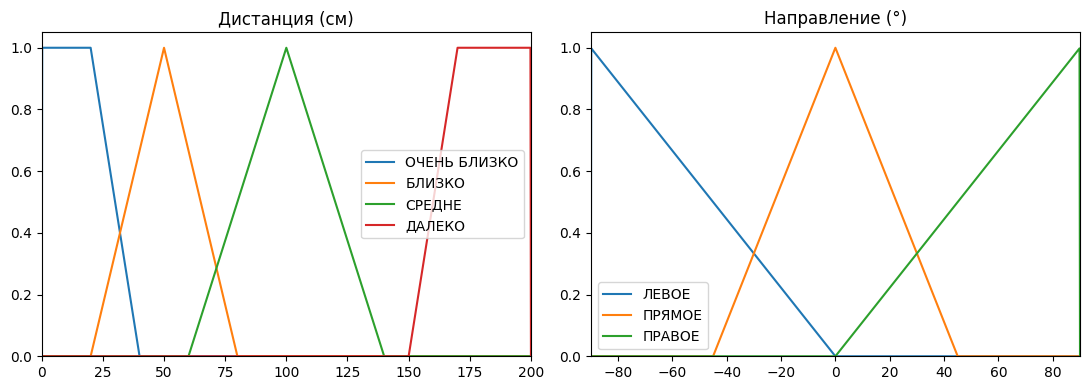

D= 15 см, dir= 30°  → рулевой угол -60.0°
D= 50 см, dir=  0°  → рулевой угол -30.0°
D=110 см, dir= 45°  → рулевой угол -30.0°
D=170 см, dir=-60°  → рулевой угол 0.0°
D= 10 см, dir=-80°  → рулевой угол 60.0°


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Универсы
x_dist = np.linspace(0, 200, 1001)     # см
x_dir  = np.linspace(-90, 90, 1001)    # градусы

# Базовые треугольные/плечевые функции
def trapmf(x, a, b, c, d):
    # Трапеция (a<=b<=c<=d)
    return np.maximum(0, np.minimum(np.minimum((x-a)/(b-a+1e-9), 1), np.minimum((d-x)/(d-c+1e-9), 1)))

def trimf(x, a, b, c):
    # Треугольник
    return np.maximum(0, np.minimum((x-a)/(b-a+1e-9), (c-x)/(c-b+1e-9)))

# ---- ДИСТАНЦИЯ: ОЧЕНЬ БЛИЗКО, БЛИЗКО, СРЕДНЕ, ДАЛЕКО
# Из текста: ОЧЕНЬ БЛИЗКО ~ 0–20; БЛИЗКО ~ 50; СРЕДНЕ ~ 100; ДАЛЕКО ~ 150–200.
# Зададим кусочно-линейно (разумные опоры для плавности):
mu_dist_very_close = trapmf(x_dist, 0, 0, 20, 40)          # левое плечо
mu_dist_close      = trimf(x_dist, 20, 50, 80)             # треугольник с центром ~50
mu_dist_medium     = trimf(x_dist, 60, 100, 140)           # центр ~100
mu_dist_far        = trapmf(x_dist, 150, 170, 200, 200)    # правое плечо

# ---- НАПРАВЛЕНИЕ: ЛЕВОЕ (-90), ПРЯМОЕ (0), ПРАВОЕ (90)
mu_dir_left   = trimf(x_dir, -90, -90,   0)   # пик в -90, спуск к 0
mu_dir_stra   = trimf(x_dir,  -45,  0,  45)   # пик в 0
mu_dir_right  = trimf(x_dir,    0, 90,  90)   # пик в 90

# Рисуем функции принадлежности
def plot_memberships():
    fig, axs = plt.subplots(1, 2, figsize=(11,4))
    axs[0].plot(x_dist, mu_dist_very_close, label='ОЧЕНЬ БЛИЗКО')
    axs[0].plot(x_dist, mu_dist_close,      label='БЛИЗКО')
    axs[0].plot(x_dist, mu_dist_medium,     label='СРЕДНЕ')
    axs[0].plot(x_dist, mu_dist_far,        label='ДАЛЕКО')
    axs[0].set_title('Дистанция (см)')
    axs[0].set_xlim(0, 200); axs[0].set_ylim(0, 1.05); axs[0].legend()

    axs[1].plot(x_dir, mu_dir_left,  label='ЛЕВОЕ')
    axs[1].plot(x_dir, mu_dir_stra,  label='ПРЯМОЕ')
    axs[1].plot(x_dir, mu_dir_right, label='ПРАВОЕ')
    axs[1].set_title('Направление (°)')
    axs[1].set_xlim(-90, 90); axs[1].set_ylim(0, 1.05); axs[1].legend()
    plt.tight_layout()
    plt.show()

# Помощники для "онлайн" расчёта μ по конкретным значениям
def interp_mu(x, xs, mu_curve):
    # Интерполяция значения функции принадлежности по заранее рассчитанной кривой
    return float(np.interp(x, xs, mu_curve))

# Константы выхода (Sugeno, 0-го порядка)
OUT = {
    'R_SHARP_LEFT':  -60.0,
    'LEFT':          -30.0,
    'STRAIGHT':        0.0,
    'RIGHT':          30.0,
    'R_SHARP_RIGHT':  60.0,
}

# Таблица правил из документа (12 правил).
# Столбцы: ПРАВОЕ / ПРЯМОЕ / ЛЕВОЕ
# Строки: ОЧЕНЬ БЛИЗКО / БЛИЗКО / СРЕДНЕ / ДАЛЕКО
# Значения: РЕЗКО ВЛЕВО, ВЛЕВО, ПРЯМО, ВПРАВО, РЕЗКО ВПРАВО.
RULES = [
    # direction = RIGHT
    ('VERY_CLOSE', 'RIGHT', 'R_SHARP_LEFT'),
    ('CLOSE',      'RIGHT', 'R_SHARP_LEFT'),
    ('MEDIUM',     'RIGHT', 'LEFT'),
    ('FAR',        'RIGHT', 'STRAIGHT'),
    # direction = STRAIGHT
    ('VERY_CLOSE', 'STRAIGHT', 'R_SHARP_LEFT'),
    ('CLOSE',      'STRAIGHT', 'LEFT'),
    ('MEDIUM',     'STRAIGHT', 'LEFT'),
    ('FAR',        'STRAIGHT', 'STRAIGHT'),
    # direction = LEFT
    ('VERY_CLOSE', 'LEFT', 'R_SHARP_RIGHT'),
    ('CLOSE',      'LEFT', 'R_SHARP_RIGHT'),
    ('MEDIUM',     'LEFT', 'RIGHT'),
    ('FAR',        'LEFT', 'STRAIGHT'),
]

def mu_distance_labels(d):
    return {
        'VERY_CLOSE': interp_mu(d, x_dist, mu_dist_very_close),
        'CLOSE':      interp_mu(d, x_dist, mu_dist_close),
        'MEDIUM':     interp_mu(d, x_dist, mu_dist_medium),
        'FAR':        interp_mu(d, x_dist, mu_dist_far),
    }

def mu_direction_labels(a):
    return {
        'LEFT':     interp_mu(a, x_dir, mu_dir_left),
        'STRAIGHT': interp_mu(a, x_dir, mu_dir_stra),
        'RIGHT':    interp_mu(a, x_dir, mu_dir_right),
    }

def sugeno_zero_order(distance_cm: float, bearing_deg: float) -> float:
    """
    distance_cm: 0..200
    bearing_deg: -90..90 (отрицательное — препятствие слева, положительное — справа)
    Возвращает рулевой угол [-60..60]: отрицательный — поворот влево, положительный — вправо.
    """
    md = mu_distance_labels(distance_cm)
    mr = mu_direction_labels(bearing_deg)

    # Вычисляем силу срабатывания каждого правила как min(μ_дистанция, μ_направление)
    weights = []
    consequents = []
    for dist_label, dir_label, out_label in RULES:
        w = min(md[dist_label], mr[dir_label])
        if w > 0:
            weights.append(w)
            consequents.append(OUT[out_label])

    if not weights:
        return 0.0

    # Sugeno: взвешенное среднее
    return float(np.dot(weights, consequents) / (np.sum(weights) + 1e-12))

# Пример использования:
if __name__ == "__main__":
    plot_memberships()
    for (d, a) in [(15,  30), (50,  0), (110,  45), (170, -60), (10, -80)]:
        ang = sugeno_zero_order(d, a)
        print(f"D={d:>3} см, dir={a:>3}°  → рулевой угол {ang:.1f}°")


Рулевой угол: -32.42°


KeyError: 'steering'

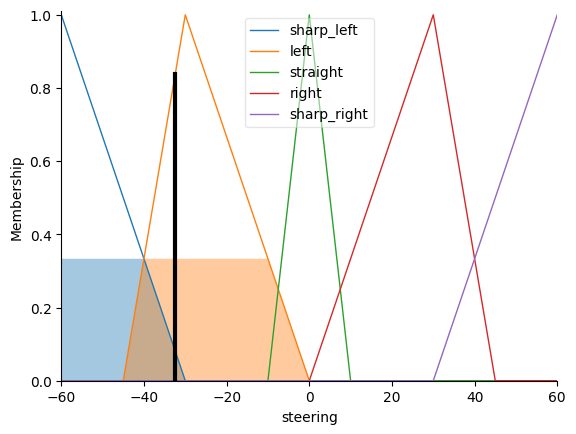

In [4]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# --- Определяем входы и выход ---
distance = ctrl.Antecedent(np.arange(0, 201, 1), 'distance')
direction = ctrl.Antecedent(np.arange(-90, 91, 1), 'direction')
steering = ctrl.Consequent(np.arange(-60, 61, 1), 'steering')

# --- Функции принадлежности ---
distance['very_close'] = fuzz.trapmf(distance.universe, [0, 0, 20, 40])
distance['close']      = fuzz.trimf(distance.universe, [20, 50, 80])
distance['medium']     = fuzz.trimf(distance.universe, [60, 100, 140])
distance['far']        = fuzz.trapmf(distance.universe, [150, 170, 200, 200])

direction['left']   = fuzz.trimf(direction.universe, [-90, -90, 0])
direction['straight'] = fuzz.trimf(direction.universe, [-45, 0, 45])
direction['right']  = fuzz.trimf(direction.universe, [0, 90, 90])

steering['sharp_left']  = fuzz.trimf(steering.universe, [-60, -60, -30])
steering['left']        = fuzz.trimf(steering.universe, [-45, -30, 0])
steering['straight']    = fuzz.trimf(steering.universe, [-10, 0, 10])
steering['right']       = fuzz.trimf(steering.universe, [0, 30, 45])
steering['sharp_right'] = fuzz.trimf(steering.universe, [30, 60, 60])

# --- Правила (по вашей таблице) ---
rules = [
    ctrl.Rule(distance['very_close'] & direction['right'], steering['sharp_left']),
    ctrl.Rule(distance['close']      & direction['right'], steering['sharp_left']),
    ctrl.Rule(distance['medium']     & direction['right'], steering['left']),
    ctrl.Rule(distance['far']        & direction['right'], steering['straight']),

    ctrl.Rule(distance['very_close'] & direction['straight'], steering['sharp_left']),
    ctrl.Rule(distance['close']      & direction['straight'], steering['left']),
    ctrl.Rule(distance['medium']     & direction['straight'], steering['left']),
    ctrl.Rule(distance['far']        & direction['straight'], steering['straight']),

    ctrl.Rule(distance['very_close'] & direction['left'], steering['sharp_right']),
    ctrl.Rule(distance['close']      & direction['left'], steering['sharp_right']),
    ctrl.Rule(distance['medium']     & direction['left'], steering['right']),
    ctrl.Rule(distance['far']        & direction['left'], steering['straight']),
]

# --- Создаём систему и симуляцию ---
steering_ctrl = ctrl.ControlSystem(rules)
robot = ctrl.ControlSystemSimulation(steering_ctrl)
robot2 = ctrl.ControlSystemSimulation(steering_ctrl)

# --- Пример расчёта ---
robot.input['distance'] = 40
robot.input['direction'] = 30
robot.compute()

print(f"Рулевой угол: {robot.output['steering']:.2f}°")
steering.view(sim=robot)

# --- Поверхность вывода ---
distance_vals = np.linspace(0, 200, 50)
direction_vals = np.linspace(-90, 90, 50)
X, Y = np.meshgrid(distance_vals, direction_vals)
Z = np.zeros_like(X)
for i in range(50):
    for j in range(50):
        robot.input['distance'] = X[i, j]
        robot.input['direction'] = Y[i, j]
        robot.compute()
        Z[i, j] = robot.output['steering']

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Distance (см)')
ax.set_ylabel('Direction (°)')
ax.set_zlabel('Steering (°)')
plt.show()


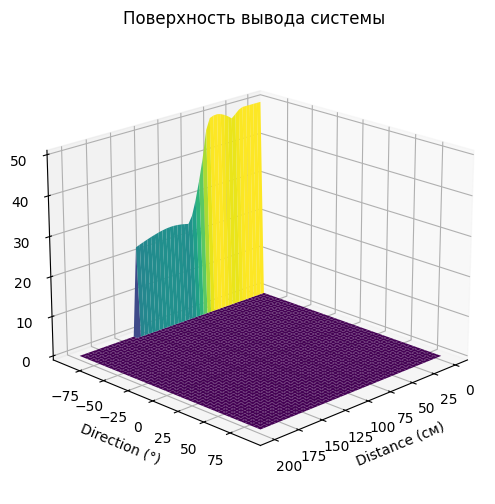

In [7]:
# --- Рисуем 3D-поверхность ---
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.view_init(elev=20, azim=45)
ax.set_title('Поверхность вывода системы')
ax.set_xlabel('Distance (см)')
ax.set_ylabel('Direction (°)')
ax.set_zlabel('Steering (°)')
plt.show()